# pcr抗原结果表重新取数的方法
主要是为了区分未送检场区和未检出场区。组内数据表中的myana.datamining_DWS_DS_antigen_UD 属于聚合表，只记录阳性结果，然而这无法区分未送检和未检出。
现在用一种新的方法尝试区分出某个场区每天的未送检和未检出，这里考虑所有的阳性阴性结果，不经过筛选。

# 数据库

In [2]:
import sys
import re
from pyhive import hive
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
import requests
import json
import time
from matplotlib import pyplot as plt

from matplotlib.font_manager import FontProperties
font = FontProperties('simhei', size=20) #中文字体


pd.set_option('display.max_columns', None) #显示所有列
sys.path.append('/data/datamining/Py_functions/get_data')
from get_data_func import * ##取数function  


In [3]:

hiveConn = hive.Connection(host='10.106.20.15', port=10000, username='szchenye', password='szcy230#',
                                       database='mydw', auth='CUSTOM')

# 取数


### pcr结果表
1.  最新数据
2. 历史数据
4. 整理

In [21]:
# 1. 最新数据 mydw.source_my_hx_result_pcr 
pcr_sql1 = '''SELECT DISTINCT left(b.sampling_time,10) AS sampling_time, c.batch_no as fbatchno,a.inspection_purpose_name,  b.scene_code AS ffieldid, b.scene_name AS ffield
, a.project_code, a.project_name, a.result_determine
FROM mydw.source_my_hx_result_pcr a
LEFT JOIN mydw.source_my_hx_sampling_sample c ON a.sample_no = c.sample_no 
LEFT JOIN mydw.source_my_hx_veterinary_sampling b ON b.id = a.sampling_id 
AND b.status != -1
WHERE a.status != -1 
AND sampling_time > '2020-12-01' '''

pcr_df1 = pd.read_sql(pcr_sql1, hiveConn)
pcr_df1

,sampling_time,fbatchno,inspection_purpose_name,ffieldid,ffield,project_code,project_name,result_determine
0,2021-09-29,NLMH0000536315268210724,疾病诊断,15409405,宁陵12场繁殖场,26120254,伪狂犬gE,阴性
1,2021-05-15,FGMH0000509210463210427,疾病诊断,15407469,扶沟9场,26120229,猪流感病毒,None
2,2021-08-15,FG525718801064232210809001,出生监控,15257188,扶沟14场,26120254,伪狂犬gE,阴性
3,2021-07-19,JP0000236276941210606,死猪监控,15380983,建平2场2区,26120207,梭菌,阴性
4,2021-11-30,YN0000327181X211016024,死猪监控,15438788,依安4场1区,26120204,巴氏杆菌,阳性
...,...,...,...,...,...,...,...,...
866959,2021-11-20,CX7401086811211110055,疾病诊断,15370578,曹县1场3区,26120211,传染性胃肠炎,阴性
866960,2021-06-04,FX290102299704210514,转群监控,15330727,阜新1场3区,26120211,传染性胃肠炎,阴性
866961,2021-06-26,DZ020501179018210507,疾病诊断,2519,邓州2场繁殖场,26120249,蓝耳,None
866962,2021-08-22,QX0000236296738210811,疾病诊断,15469912,杞县7场,26120211,传染性胃肠炎,阴性


In [24]:
#2. 历史数据
# -- source_my_sy_pcrresult 中， + 表示阳性，-表示阴性，空表示测的是别的病
pcr_sql2 = '''SELECT LEFT(sample.`fsampledate`,10) AS sampling_time, sample.`fbatchno`, sample.fsampleintent AS inspection_purpose_name, sample.ffieldid, sample.ffield,  
pcr.project_code, pcr.project_name, pcr.result_determine  FROM (
SELECT fsampleno, '26120250' AS project_code, '猪流行性腹泻' AS project_name ,
(CASE WHEN ped LIKE '+' THEN '阳性'WHEN ped LIKE '-' THEN '阴性' END) AS result_determine 
FROM mydw.source_my_sy_pcrresult) pcr 
LEFT JOIN mydw.source_my_sy_serumsample sample ON pcr.fsampleno = sample.fsampleno
WHERE left(sample.fsampledate, 10) > '2020-12-01' '''

pcr_df2 = pd.read_sql(pcr_sql2, hiveConn)
pcr_df2


,sampling_time,fbatchno,inspection_purpose_name,ffieldid,ffield,project_code,project_name,result_determine
0,2020-12-02,TX780636190162201112,疾病诊断,15168579,通许4场,26120250,猪流行性腹泻,None
1,2020-12-03,FX280603165956201124,疾病诊断,15330726,阜新1场2区,26120250,猪流行性腹泻,None
2,2020-12-03,ZY190236203784201119,疾病诊断,15317054,正阳4场2区,26120250,猪流行性腹泻,None
3,2020-12-04,FS910201180094201201,死猪监控,15335445,繁峙11场,26120250,猪流行性腹泻,None
4,2020-12-04,YJ0000522194984200812,疾病诊断,15396341,永济17场,26120250,猪流行性腹泻,None
...,...,...,...,...,...,...,...,...
248921,2021-05-11,NA0000336151272210408,病原流调（不同日龄类）,15424903,农安3场生长场,26120250,猪流行性腹泻,None
248922,2021-05-14,NL0000617187366210424,疾病诊断,15384231,宁陵22场,26120250,猪流行性腹泻,None
248923,2021-05-14,NLMH0000201233431210415,疾病诊断,15414425,宁陵18场,26120250,猪流行性腹泻,None
248924,2021-05-11,NA970205222582210322,转群监控,15314535,农安2场,26120250,猪流行性腹泻,None


### pcr定量结果表
1.  最新数据
2. 历史数据
4. 整理

In [25]:
# 最新数据
pcrdl_sql1 = '''SELECT DISTINCT left(b.sampling_time,10) AS sampling_time, c.batch_no as fbatchno ,a.inspection_purpose_name, b.scene_code AS ffieldid, b.scene_name AS ffield,
a.project_code, a.project_name, a.result_determine
FROM mydw.source_my_hx_result_quantitative_pcr a
LEFT JOIN mydw.source_my_hx_sampling_sample c ON a.sample_no = c.sample_no 
LEFT JOIN mydw.source_my_hx_veterinary_sampling b ON b.id = a.sampling_id 
AND b.status != -1
WHERE a.status != -1 AND sampling_time > '2020-12-01' '''
pcrdl_df1 = pd.read_sql(pcrdl_sql1, hiveConn)
pcrdl_df1

,sampling_time,fbatchno,inspection_purpose_name,ffieldid,ffield,project_code,project_name,result_determine
0,2021-11-02,待配15单元,死猪监控,15176675,大荔1场1区,26120106,伪狂犬gE,阴性
1,2021-10-24,XX0000236256721210823,死猪监控,15416804,夏县8场,26120122,A,阴性
2,2021-10-28,,生物安全,15527605,扶沟19场2区,26120122,A,阴性
3,2021-12-11,KQ00005154312211102009,疾病诊断,15403979,科左中旗6场,26120108,猪流感病毒,阴性
4,2021-06-27,GZ700336232390210527,死猪监控,15370126,广宗9场,26120106,伪狂犬gE,None
...,...,...,...,...,...,...,...,...
10471523,2021-12-04,WM00003182737211031144,死猪监控,15481507,武鸣1场生长场2区,26120122,A,阴性
10471524,2021-12-09,HM552291704110910210914013,死猪监控,15522917,惠民2场繁殖场2区,26120122,A,阴性
10471525,2021-12-31,LHK260224551X211108034,死猪监控,15318091,老河口5场生长场2区,26120122,A,阴性
10471526,2021-12-13,JS0000401451X211102002,死猪监控,15436735,海口2场繁殖场,26120122,A,阴性


In [26]:
# 历史数据
pcrdl_sql2 = '''SELECT LEFT(sample.`fsampledate`,10) AS sampling_time, sample.`fbatchno`,sample.fsampleintent AS inspection_purpose_name, sample.ffieldid, sample.ffield, 
pcr.project_code, pcr.project_name, pcr.result_determine
FROM (
SELECT finspectno AS id,fsampleno, '26120250' AS project_code,
'猪流行性腹泻' AS project_name, (CASE WHEN ped_bd>0 OR  ped_ct >0 THEN '阳性' WHEN ped_bd = 0 OR  ped_ct = 0 THEN '阴性' end) AS result_determine 
FROM mydw.source_my_sy_pcrdlresult WHERE fsampleno IS NOT NULL ) pcr
LEFT JOIN mydw.source_my_sy_serumsample sample ON pcr.fsampleno = sample.fsampleno
WHERE LEFT(sample.fsampledate, 10) > '2020-12-01' '''
pcrdl_df2 = pd.read_sql(pcrdl_sql2, hiveConn)
pcrdl_df2

,sampling_time,fbatchno,inspection_purpose_name,ffieldid,ffield,project_code,project_name,result_determine
0,2020-12-02,NX2105080125200805,疾病诊断,915.0,内乡21场繁殖场,26120250,猪流行性腹泻,None
1,2020-12-02,KD990505227412200802,疾病诊断,15348435.0,克东2场,26120250,猪流行性腹泻,None
2,2020-12-02,/,生物安全,94.0,颍上饲料厂,26120250,猪流行性腹泻,None
3,2020-12-02,MD550225211621201124,生物安全,15369161.0,牡丹1场1、2区,26120250,猪流行性腹泻,None
4,2020-12-02,WL020203166742200928,死猪监控,2512.0,卧龙2场生长场,26120250,猪流行性腹泻,None
...,...,...,...,...,...,...,...,...
4515760,2021-04-29,/,生物安全,15332703.0,奈曼9场繁殖场,26120250,猪流行性腹泻,None
4515761,2021-04-29,NM750536201595210101,疾病诊断,15298923.0,奈曼1场,26120250,猪流行性腹泻,None
4515762,2021-05-30,/,疾病诊断,15376511.0,平原1场1区,26120250,猪流行性腹泻,None
4515763,2021-04-29,/,生物安全,15331406.0,奈曼4场,26120250,猪流行性腹泻,None


In [30]:
# #为了保命先保存
# pcr_df1.to_csv('pcr_df1.csv', index = False)
# pcr_df2.to_csv('pcr_df2.csv', index = False)
# pcrdl_df1.to_csv('pcrdl_df1.csv', index = False)
# pcrdl_df2.to_csv('pcrdl_df2.csv', index = False)

### 整理
1. 场区ped未送检 = 当天没采样+采样但没检测PED ； 对的
2. 场区ped未检出 = 所有ped送检样本为阴性；对的 空值不能代表未检出而是根本就没检
3. 场区ped检出 = 至少一个ped送检样本为阳性 是对的


In [7]:
pcr_df1 = pd.read_csv('pcr_df1.csv')
pcr_df2 = pd.read_csv('pcr_df2.csv')
pcrdl_df1 = pd.read_csv('pcrdl_df1.csv')
pcrdl_df2 = pd.read_csv('pcrdl_df2.csv')

In [8]:
pcr_df1_copy = pcr_df1.copy()
pcr_df2_copy = pcr_df2.copy()
pcrdl_df1_copy = pcrdl_df1.copy()
pcrdl_df2_copy = pcrdl_df2.copy()

In [9]:
#合并
all_ped_data = pcr_df1_copy.append(pcr_df2_copy, ignore_index = False).append(pcrdl_df1_copy, ignore_index = False).append(pcrdl_df2_copy, ignore_index = False).sort_values(by= 'sampling_time')
# 修改格式
all_ped_data.ffieldid = all_ped_data.ffieldid.astype(float)

In [10]:
# 整理到一起，只选择ped , 结果只选择‘阴性’或者‘阳性’
all_ped = all_ped_data.loc[((all_ped_data.result_determine == '阳性')|(all_ped_data.result_determine == '阴性'))&(all_ped_data.project_name == '猪流行性腹泻')]

In [11]:
all_ped #所有批次的检测结果都包含在里面，同时也包含了其他目的的检测及检测结果

,sampling_time,fbatchno,inspection_purpose_name,ffieldid,ffield,project_code,project_name,result_determine
2386180,2020-12-02,GZ0000517184604200801,返饲（前）后病原检测,15424804.0,广宗5场繁殖场,26120250.0,猪流行性腹泻,阴性
2386177,2020-12-02,/,生物安全,15173775.0,商水4场2区,26120250.0,猪流行性腹泻,阴性
2386185,2020-12-02,/,生物安全,-10137.0,西平消毒站,26120250.0,猪流行性腹泻,阴性
535335,2020-12-02,NX0000319216589200910,外区域供种,15417531.0,内乡21场生长场,26120250.0,猪流行性腹泻,阴性
535349,2020-12-02,NJ0000301231599201109,试验追踪,15407339.0,宁晋2场,26120250.0,猪流行性腹泻,阴性
...,...,...,...,...,...,...,...,...
29236,2022-02-16,NaN,车辆检测,210514311.0,大荔牧原消毒站,26120116.0,猪流行性腹泻,阴性
7700400,2022-02-16,KD0230M00602122120220121010,死猪监控,15431119.0,克东牧原4场综合场,26120116.0,猪流行性腹泻,阴性
6489212,2022-02-16,KD0230M00602122120220121009,死猪监控,15431119.0,克东牧原4场综合场,26120116.0,猪流行性腹泻,阴性
4615561,2022-02-16,NaN,车辆检测,2105174.0,昌图牧原洗消中心,26120116.0,猪流行性腹泻,阴性


In [60]:
hiveConn2 = hive.Connection(host='10.106.20.15', port=10000, username='szchenye', password='szcy230#',
                                       database='myana', auth='CUSTOM')
# 场区列表
field_sql = '''SELECT DISTINCT ffieldid, ffield FROM  myana.datamining_DIM_AF '''
field_df = pd.read_sql(field_sql, hiveConn2)
#场区id列表
field_list = list(field_df.ffieldid)

In [73]:
# 时间列表, 2021年
time_list = [(datetime.strptime('2021-01-01', "%Y-%m-%d") + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(0,365,1)]

In [98]:
# 创建新的列表
# 贴上标签 ： 检出，未检出，未送检
ped_label = pd.DataFrame(columns = ['ffieldid', 'sampling_time', 'result_determine'])
#先添加一个场区的全年信息
ped_label.sampling_time = time_list 
ped_label.ffieldid = field_list[0]


def get_new_base(ped_label):
    '''重新取数的基础表，包含场区id，采样时间（2021年每天）， PED送检情况
    '''
    output = ped_label.copy()
    for i in range(1,len(field_list)):
        one_field = pd.DataFrame(columns =['ffieldid', 'sampling_time', 'result_determine'])
        one_field.sampling_time = time_list
        one_field.ffieldid = field_list[i] 
        output = output.append(one_field, ignore_index = True )
        
        
    return output 

get_new_base(ped_label)

,ffieldid,sampling_time,result_determine
0,15618805,2021-01-01,NaN
1,15618805,2021-01-02,NaN
2,15618805,2021-01-03,NaN
3,15618805,2021-01-04,NaN
4,15618805,2021-01-05,NaN
...,...,...,...
682180,15382148,2021-12-27,NaN
682181,15382148,2021-12-28,NaN
682182,15382148,2021-12-29,NaN
682183,15382148,2021-12-30,NaN


给每个场区每天都整一个标签

In [92]:
# 例子  15376130 馆陶牧原5场繁殖场
all_ped.loc[(all_ped.ffieldid == 15376130) &(all_ped.sampling_time == '2021-01-25')]

,sampling_time,fbatchno,ffieldid,project_name,result_determine,ffield
16589217,2021-01-25,岳俊尚,15376130.0,猪流行性腹泻,阴性,NaN
4926085,2021-01-25,预清洗前,15376130.0,猪流行性腹泻,阴性,NaN
14526751,2021-01-25,无,15376130.0,猪流行性腹泻,阴性,NaN
3007496,2021-01-25,无,15376130.0,猪流行性腹泻,阴性,NaN
17854511,2021-01-25,无,15376130.0,猪流行性腹泻,阴性,NaN
11172954,2021-01-25,无,15376130.0,猪流行性腹泻,阴性,NaN
14511186,2021-01-25,无,15376130.0,猪流行性腹泻,阴性,NaN
13632835,2021-01-25,GT0000109180215201005,15376130.0,猪流行性腹泻,阴性,NaN
13949589,2021-01-25,预清洗前,15376130.0,猪流行性腹泻,阴性,NaN
10188773,2021-01-25,GT0000136191641210115,15376130.0,猪流行性腹泻,阴性,NaN


由上面的输出可以看出，场区15376130 在2021-01-25有阳性输出，按照定义应该等于"检出” 

In [99]:
def get_day_label(field_table,date):
    '''输出该场区当天的PED检测结果
    输出：检出，未检出, 未送检
    场区ped未送检 = 当天没采样+采样但没检测PED ；
    场区ped未检出 = 所有ped送检样本为阴性； 空值不能代表未检出而是根本就没检
    场区ped检出 = 至少一个ped送检样本为阳性 
    field_table : dataframe， 某个场区id的全部检测信息
    date: string, 输入时间
    '''
    result_list =list(field_table.loc[field_table.sampling_time == date].result_determine.values) 
    if len(result_list) == 0:
        return '未送检'
    elif '阳性' in result_list:
        return '检出'
    else: 
        return '未检出'

get_day_label(all_ped.loc[all_ped.ffieldid == 15376130], '2021-01-25') #输出成果符合预期

'检出'

In [118]:
# 填充场区
new_base_df = get_new_base(ped_label)

In [140]:
aa = new_base_df.loc[new_base_df.ffieldid == 15376130]
info_field = all_ped.loc[all_ped.ffieldid == 15376130]
aa.result_determine = [get_day_label(info_field, time) for time in time_list]

/data/envir/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [143]:
aa

,ffieldid,sampling_time,result_determine
46720,15376130,2021-01-01,未送检
46721,15376130,2021-01-02,未送检
46722,15376130,2021-01-03,未送检
46723,15376130,2021-01-04,未送检
46724,15376130,2021-01-05,未送检
...,...,...,...
47080,15376130,2021-12-27,未检出
47081,15376130,2021-12-28,未检出
47082,15376130,2021-12-29,未检出
47083,15376130,2021-12-30,未检出


In [146]:
def fullfill_ped(new_base_df, time_list):
    '''填充所有的场区和每一天
    对于无法匹配的场区，输出无法判断'''
    new_base_df_copy = new_base_df.copy()
    for fieldid in field_list: 
        field_table = all_ped.loc[all_ped.ffieldid == fieldid]
        if field_table.empty: #空集则代表无法匹配
            new_base_df_copy.loc[new_base_df.ffieldid == fieldid, 'result_determine'] = '无法匹配'
        else: 
            new_base_df_copy.loc[new_base_df.ffieldid == fieldid, 'result_determine'] = [get_day_label(field_table, time) for time in time_list]
    return new_base_df_copy

In [147]:
fullfill_ped(new_base_df, time_list)

,ffieldid,sampling_time,result_determine
0,15618805,2021-01-01,无法匹配
1,15618805,2021-01-02,无法匹配
2,15618805,2021-01-03,无法匹配
3,15618805,2021-01-04,无法匹配
4,15618805,2021-01-05,无法匹配
...,...,...,...
682180,15382148,2021-12-27,未送检
682181,15382148,2021-12-28,未送检
682182,15382148,2021-12-29,未送检
682183,15382148,2021-12-30,未送检


In [148]:
new_ped_data = fullfill_ped(new_base_df, time_list)

In [152]:
#new_ped_data.to_csv('重新取数数据表/抗原检测重新取数成果.csv', index = False )

(array([122640.,      0.,      0., 366223.,      0.,      0., 170982.,
             0.,      0.,  22340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

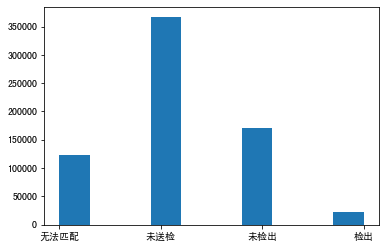

In [154]:
# 正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']

plt.hist(new_ped_data.result_determine)

# 字段取数

#### 输出标签

In [4]:
# y
# 输出取数

new_ped_data = pd.read_csv('抗原检测重新取数成果.csv')
# 场区列表
hiveConn2 = hive.Connection(host='10.106.20.15', port=10000, username='szchenye', password='szcy230#',
                                       database='myana', auth='CUSTOM')

field_sql = '''SELECT DISTINCT ffieldid, ffield FROM  myana.datamining_DIM_AF '''
field_df = pd.read_sql(field_sql, hiveConn2)
new_ped_data = new_ped_data.merge(field_df, how = 'left', on = 'ffieldid')
# 贴上标签
def sickmodel_label(new_ped_data):
    '''给发病模型贴标签。正样本为该场区检出PED前15天（包括检出当天）， 负样本为其他时间
    输入：dataframe
    输出：dataframe, 所有场区2021-01-01 到2022-01-03每天的标签
    输入正样本：该场区哺乳仔猪检出PED的前15天 （包括第15天） 输出负样本：该场区哺乳仔猪无检出PED（未检出）'''
    
    new_ped_data_copy = new_ped_data.copy()
    
    #首先定义所有未送检为负样本
    new_ped_data_copy.loc[new_ped_data_copy.result_determine == '未检出', 'label'] = 0
    
    #其次定义所有检出，前15天包括第15天，为正样本 
    positive_index_list = list(new_ped_data.loc[(new_ped_data.result_determine == '检出')&(new_ped_data.sampling_time > '2021-01-15')].index) #所有检出的序列列表, 在1月15日之前检出的不考虑研究
    for i in positive_index_list:
        new_ped_data_copy.iloc[i-15:i+1, -1] = 1
        
    # 但这种做法也会导致一些’无法匹配‘的场区配到label = 1的标签
    # 所以要经过再一轮的筛选，剩下有label并且不是无法判断的场区
    output = new_ped_data_copy.loc[(new_ped_data_copy.result_determine != '无法匹配')&(new_ped_data_copy.label.notnull())]
        
    return output
        
labelled_data = sickmodel_label(new_ped_data)

#### 哺乳猪群PED阳性单元数
定量PCR明细表中送检原因是疾病诊断和疾病诊断（加测）中，哺乳猪群内检出PED抗原单元数量

 定义
- 未送检： 30天没采样，采样没采PED， 采了PED但是没有包括哺乳批次
- 未检出：哺乳批次30天的样本结果都是阴性, 送检原因是疾病诊断和疾病诊断（加测）
- 检出：哺乳批次30天的样本有阳性，送检原因是疾病诊断和疾病诊断（加测）
- 0.0：就是未检出？？

例子：
1. 一个保育批次检出PED阳性， 其他批次没有送检结果 -- 未送检
2.  30天内该场区没有送检任何批次 -- 未送检
3. 一个哺乳批次检出PED---检出
4. 一个哺乳猪群批次PED阴性。




In [5]:
labelled_data

,ffieldid,sampling_time,result_determine,ffield,label
731,15337544,2021-01-02,未检出,界首牧原6场繁殖场,0.0
733,15337544,2021-01-04,未检出,界首牧原6场繁殖场,0.0
734,15337544,2021-01-05,未检出,界首牧原6场繁殖场,0.0
735,15337544,2021-01-06,未检出,界首牧原6场繁殖场,0.0
737,15337544,2021-01-08,未检出,界首牧原6场繁殖场,0.0
...,...,...,...,...,...
681289,15382252,2021-07-19,未检出,新河牧原试验场,0.0
681292,15382252,2021-07-22,未检出,新河牧原试验场,0.0
681293,15382252,2021-07-23,未检出,新河牧原试验场,0.0
681361,15382252,2021-09-29,未检出,新河牧原试验场,0.0


In [12]:
def get_feature1(field_id, all_ped, base_df):
    '''字段1-哺乳猪群PED阳性单元数
    field_id: float, 场区id
    all_ped: df 信息汇总表格
    base_df: df 基础表
    整理该场区在该时间前30天内，哺乳猪群内检出PED抗原单元数量, 限制条件：送检原因是疾病诊断和疾病诊断（加测）
    - 未送检： 30天没采样，采样没采PED， 采了PED但是没有包括哺乳批次
    - 未检出：哺乳批次30天的样本结果都是阴性
    - 检出：哺乳批次30天的样本有阳性
    - 0.0：
    '''
    field_data = all_ped.loc[all_ped.ffieldid == field_id]
    #哺乳批次信息罗列
    batch_info_sql = '''SELECT fbatchno, fsegmentid, ffeeder_name, funitnames  FROM myana.datamining_DWD_BI where fsegmentid = 13905 '''
    batch_info = pd.read_sql(batch_info_sql, hiveConn)
    time_list_1y = [(datetime.strptime('2021-01-01', "%Y-%m-%d") + timedelta(days = i)).strftime("%Y-%m-%d")  for i in range(0,365)]
    
    def get_feature1_value(time):
        '''每个当前时间前30天的特征值
        time: string. 当前时间'''
        starttime, endtime = (datetime.strptime(time, "%Y-%m-%d") - timedelta(days = 30)).strftime("%Y-%m-%d"), time
        #送检的所有疾病诊断和疾病诊断（加测） 的结果：包括阴性和阳性
        songjian_batch = field_data.loc[(field_data.sampling_time > starttime)&(field_data.sampling_time < endtime)&((field_data.inspection_purpose_name == '疾病诊断')|(field_data.inspection_purpose_name == '疾病诊断（加测）'))]
        
        #用批次信息表和上面结果表匹配出哺乳批次的结果，然后计算阳性的个数即阳性单元的个数。如果阳性个数为0，则为未检出
        songjian_batchinfo_match = songjian_batch.merge(batch_info, how = 'inner', on = 'fbatchno')
        
        if songjian_batchinfo_match.empty: 
            feature_value = '未送检'
        else:
            feature_value = songjian_batchinfo_match.loc[songjian_batchinfo_match.result_determine == '阳性'].shape[0]
        return feature_value
        
    base_df.loc[base_df.ffieldid == field_id, 'feature1'] = [get_feature1_value(x) for x in list(base_df.loc[base_df.ffieldid == field_id].sampling_time.values)]
    
    return base_df
        

get_feature1(15337544, all_ped,labelled_data)

,ffieldid,sampling_time,result_determine,ffield,label,feature1
731,15337544,2021-01-02,未检出,界首牧原6场繁殖场,0.0,2
733,15337544,2021-01-04,未检出,界首牧原6场繁殖场,0.0,2
734,15337544,2021-01-05,未检出,界首牧原6场繁殖场,0.0,2
735,15337544,2021-01-06,未检出,界首牧原6场繁殖场,0.0,2
737,15337544,2021-01-08,未检出,界首牧原6场繁殖场,0.0,2
...,...,...,...,...,...,...
681289,15382252,2021-07-19,未检出,新河牧原试验场,0.0,NaN
681292,15382252,2021-07-22,未检出,新河牧原试验场,0.0,NaN
681293,15382252,2021-07-23,未检出,新河牧原试验场,0.0,NaN
681361,15382252,2021-09-29,未检出,新河牧原试验场,0.0,NaN


In [13]:
# 应用到所有场区的第一个字段
feature1_df = labelled_data.copy()
for fieldid in list(labelled_data.ffieldid.unique()):
    feature1_df = get_feature1(fieldid, all_ped, feature1_df)

In [14]:
feature1_df

,ffieldid,sampling_time,result_determine,ffield,label,feature1
731,15337544,2021-01-02,未检出,界首牧原6场繁殖场,0.0,2
733,15337544,2021-01-04,未检出,界首牧原6场繁殖场,0.0,2
734,15337544,2021-01-05,未检出,界首牧原6场繁殖场,0.0,2
735,15337544,2021-01-06,未检出,界首牧原6场繁殖场,0.0,2
737,15337544,2021-01-08,未检出,界首牧原6场繁殖场,0.0,2
...,...,...,...,...,...,...
681289,15382252,2021-07-19,未检出,新河牧原试验场,0.0,未送检
681292,15382252,2021-07-22,未检出,新河牧原试验场,0.0,未送检
681293,15382252,2021-07-23,未检出,新河牧原试验场,0.0,未送检
681361,15382252,2021-09-29,未检出,新河牧原试验场,0.0,未送检
